# Neural net: Barrier option pricer

Taken from 'Discrete Barrier Option Pricing'

In [27]:
'''
Packages to import
'''
import sobol_seq
import numpy as np
from numpy.linalg import multi_dot
import math
from scipy.stats import norm
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.callbacks import EarlyStopping
import keras.optimizers as opt
from sklearn.cluster import KMeans
from keras.constraints import Constraint
from keras import backend as keras_backend
import time
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import kurtosis
from scipy.stats import skew
import matplotlib.pyplot as plt
from numpy import genfromtxt
from numpy import savetxt
import time

In [31]:
'''
Code is written with tensorflow v1, as tf v2 is used used compat.v1
Configure hardware
'''
import tensorflow as tf

num_cores = 32
GPU = 1
CPU = not GPU
if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.compat.v1.Session(config=config)
keras_backend.set_session(session)

In [39]:
def generate_covariance_from_correlation(cor_mat, vol_list, dt):
    vol_diag_mat = np.diag(vol_list)
    cov_mat = np.dot(np.dot(vol_diag_mat,cor_mat),vol_diag_mat)*dt
    return cov_mat

def multi_variate_gbm_simulation(no_of_paths, no_of_exercise_days, no_of_assets, 
                                 curr_stock_price, r, vol_list, cov_mat, dt):
    zero_mean = np.zeros(no_of_assets)
    
    #Antithetic variance reduction for monte-carlo
    w_matx = np.random.multivariate_normal(zero_mean, cov_mat, (int(no_of_paths/2),no_of_exercise_days))
    w_mat= np.concatenate((w_matx,- w_matx),axis=0)
    w_mat = w_mat.reshape(no_of_paths, no_of_exercise_days)
    
    sim_ln_stock_mat = np.zeros((no_of_paths, no_of_exercise_days + 1))
    sim_ln_stock_mat[:,0] = np.log(curr_stock_price)
  
    base_drift =  (r - 0.5 * np.square(vol_list[0])) * dt
    
    for day in range(1, no_of_exercise_days+1):
        curr_drift = sim_ln_stock_mat[:,day-1] + base_drift
        sim_ln_stock_mat[:,day] = curr_drift + w_mat[:,day-1]

    sim_stock_mat = np.exp(sim_ln_stock_mat)
    
    return sim_stock_mat

In [40]:
class Between(Constraint):
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):        
        return keras_backend.clip(w, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}

def pricer_down_out_barrier_by_nn(no_of_paths, no_of_barrier_points, sim_stock_mat, batch_size, no_of_epochs, no_of_hidden_nodes, no_of_output_nodes, t, nnet_model, min_mat, barrier):

    continuation_value = np.ones((no_of_paths, 1))
    option_value = np.zeros((no_of_paths, 1))
    
    #Finding intrinsic value of the option for all paths and exercise days
    dt = t/no_of_barrier_points
    es = EarlyStopping(monitor='loss', mode='min', patience=5) 
    continuation_value = np.maximum(sim_stock_mat[:,no_of_barrier_points] - k, 0)
    
    for day in range(no_of_barrier_points-1, -1, -1):
        
        stock_vec = sim_stock_mat[:,day+1]
        
        time_to_maturity = t - (t/no_of_barrier_points)
        barrier_pricing = lambda s: discrete_barrier_down_price(s, k, r, vol_list[0], time_to_maturity, barrier, dt)
        find_barrier_price = np.vectorize(barrier_pricing)
        
        continuation_value = find_barrier_price(stock_vec)
        continuation_value = np.multiply(continuation_value, min_mat[:,day+1])         
        option_value= np.maximum(continuation_value, 0)
        
        X_train = np.log(stock_vec)
        X_train = X_train.reshape(-1,1)
       
        Y_train = option_value
        Y_train = np.asarray(Y_train)
        Y_train.reshape(-1,1,1)
        
        nnet_output = nnet_model.fit(X_train, Y_train , epochs=no_of_epochs, batch_size=batch_size, verbose=0,validation_split=0.3, callbacks=[es])            
        w_vect = np.array(nnet_model.layers[0].get_weights()[0]).reshape(-1)
        w_vect_2 = np.array(nnet_model.layers[1].get_weights()[0]).reshape(-1)
        strikes = np.array(nnet_model.layers[0].get_weights()[1]).reshape(-1)
        bias_2 = np.array(nnet_model.layers[1].get_weights()[1]).reshape(-1)
        strikes = np.asarray(strikes)    
        
        stock_vec = sim_stock_mat[:,day]
        vol = vol_list[0]
        opt_val = np.zeros((no_of_paths, 1))
        x = np.log(stock_vec)+((r-0.5* np.square(vol))*dt)
        
        no_of_options = np.sum((np.multiply(np.sign(w_vect), np.sign(strikes)))<0)
        
        for node in range(0,no_of_hidden_nodes):
                w_o = w_vect[node]
                mu = x*w_o+strikes[node]
                var = (w_o*cov_mat[0]*w_o)
                sd = var**0.5
                ft = mu*(1-norm(0,sd).cdf(-mu))
                st = (sd/(2*math.pi)**0.5)*np.exp(-0.5*(mu/sd)**2)
                opt_val[:,0] = opt_val[:,0]+ w_vect_2[node]*(ft + st)
        continuation_value = (opt_val[:,0]+bias_2)*np.exp(-r*dt)
        
    return(np.mean(continuation_value))

def pricer_down_out_barrier_by_nn_pre(no_of_paths, no_of_barrier_points, sim_stock_mat, batch_size, no_of_epochs, no_of_hidden_nodes, no_of_output_nodes, t, nnet_model, min_mat):
    
    continuation_value = np.zeros((no_of_paths, 1))
    
    dt = t/no_of_barrier_points
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
    
    for day in range(no_of_barrier_points-1,no_of_barrier_points-2, -1):
                
        stock_vec = sim_stock_mat[:,day+1]
        
        intrinsic_value = np.maximum(stock_vec - k, 0)
        option_value = np.multiply(intrinsic_value, min_mat[:,day+1]) 
        
        X_train = stock_vec
        X_train = X_train.reshape(-1, 1)
        
        Y_train = option_value
        Y_train = np.asarray(Y_train)
        Y_train.reshape(-1,1,1)
        
        nnet_output = nnet_model.fit(X_train, Y_train , epochs=no_of_epochs, batch_size=batch_size, verbose=0, validation_split=0.3, callbacks=[es])

    return nnet_model

In [41]:
def BSM_call(s_t, k, r, vol, dt):
    d_1_c = (1 / (vol * (dt ** 0.5))) 
    d1_log =  (np.log((s_t)/(k)) + ((r + (vol ** 2) / 2) * dt))
    d_1 = d_1_c * d1_log
    d_2 = d_1 - vol * (dt ** 0.5)
    return (np.multiply(norm.cdf(d_1),  s_t) - (norm.cdf(d_2) * k * np.exp(-r * dt)))

def continuous_barrier_down_out_call(s_t, k, r, vol, dt, B):
    call_price = BSM_call(s_t, k, r, vol, dt)
    new_s = (B**2) / s_t
    adjusted_call =  BSM_call(new_s, k, r, vol, dt)
    barrier_price = call_price - ((s_t/B)**(1 - 2*r/(vol**2))) * adjusted_call
    return (barrier_price)                               
                                  
def discrete_barrier_down_price(s_t, k, r, vol, T_t, B, dt):
    beta = 0.5826
    discrete_correction = beta * vol * ((dt)**0.5)
    corrected_barrier = B * np.exp(- discrete_correction)
    return (continuous_barrier_down_out_call(s_t, k, r, vol, T_t, corrected_barrier)) 


## Initialize simulation

In [35]:
#Down and Out Barrier call option Pricing and Hedging
# Comparison with Broadie and Glasserman Paper - results on 5 barrier points

no_of_assets = 1
cor_mat = [[1]]
vol_list = np.array([0.3])
curr_stock_price = 1*np.ones(no_of_assets)
t = 0.2
k = 1
barrier_list = [0.85, 0.87, 0.89, 0.91, 0.93, 0.95, 0.97, 0.99]
# barrier_list = [0.85]
no_of_barrier_points = 5
finer_path_multiplier = 1
r = 0.1
w = np.array([1])
w = w.reshape(-1,1)
no_of_paths = 500
Notional = 100

#Generate covariance matrix 
dt = t/no_of_barrier_points
cov_mat = generate_covariance_from_correlation(cor_mat, vol_list, dt)

#Generating stock prices for training neural network
sim_stock_mat = multi_variate_gbm_simulation(no_of_paths, no_of_barrier_points, no_of_assets, 
                                                      curr_stock_price, r, vol_list, cov_mat, dt)
np.savetxt("Vikranth - Barrier Option Analysis/np_sim_stocks.csv", sim_stock_mat, delimiter=",")
sim_stock_mat = np.genfromtxt("Vikranth - Barrier Option Analysis/np_sim_stocks.csv", delimiter=',')


In [36]:
%%time
# Nnet Initialisation
batch_size = int(no_of_paths/10)
no_of_epochs = 100
no_of_hidden_nodes = 20
no_of_output_nodes = 1

#Learning starting weights
nnet_model = Sequential()
nnet_model.add(Dense(no_of_hidden_nodes, activation='relu',kernel_initializer = 'random_uniform'))
nnet_model.add(Dense(1, activation='linear',kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None)))
#nnet_model.compile(optimizer=opt.Adam(lr=1.5e-3), loss='mean_squared_error')
nnet_model.compile(optimizer= tf.optimizers.Adam(lr=1.5e-3), loss='mean_squared_error')


# no_of_runs = 30
no_of_runs = 1
df_barrier_pv = pd.DataFrame(columns=['Barrier: ' + str(barrier) for barrier in barrier_list], 
                             index=[i for i in range(1, no_of_runs+1)])
df_barrier_runtime = pd.DataFrame(columns=['Barrier: ' + str(barrier) for barrier in barrier_list], 
                             index=[i for i in range(1, no_of_runs+1)])

for i in range(0, len(barrier_list)):
    #Identifying region where stock prices hit the barrier
    barrier = barrier_list[i]
    I = (sim_stock_mat > barrier)
    price_list=[]
    run_time=[]
    
    for j in range(0, no_of_runs):
        nnet_model = Sequential()
        nnet_model.add(Dense(no_of_hidden_nodes, activation='relu',kernel_initializer = 'random_uniform'))
        nnet_model.add(Dense(1, activation='linear',kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None)))
        #nnet_model.compile(optimizer=opt.Adam(lr=1.5e-3), loss='mean_squared_error')
        nnet_model.compile(optimizer= tf.optimizers.Adam(lr=1.5e-3), loss='mean_squared_error')
        nnet_model = pricer_down_out_barrier_by_nn_pre(no_of_paths, no_of_barrier_points, sim_stock_mat, batch_size, no_of_epochs, no_of_hidden_nodes, no_of_output_nodes, t, nnet_model, I)
    
        #Training Neural Network for barrier pricing
        no_of_epochs = 30
        
        start_time = time.time()
        price = pricer_down_out_barrier_by_nn(no_of_paths, no_of_barrier_points, sim_stock_mat, batch_size, no_of_epochs, no_of_hidden_nodes, no_of_output_nodes, t, nnet_model, I, barrier)
        elapsed_time_secs = time.time() - start_time
        
        price_list.append(price)
        run_time.append(elapsed_time_secs)
    
    df_barrier_pv.loc[:,['Barrier: ' + str(barrier)]] = np.array(price_list).reshape(-1,1)
    df_barrier_runtime.loc[:,['Barrier: ' + str(barrier)]] = np.array(run_time).reshape(-1,1)
     
df_barrier_pv.to_csv("df_barrier_pv.csv")
df_barrier_runtime.to_csv("df_barrier_pv_run_time.csv")

C:\Users\sebas\anaconda3\envs\py39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Wall time: 1min 7s


## Plot analytical versus numerical

In [46]:
broadie_glassermen_price = [discrete_barrier_down_price(curr_stock_price, k, r, vol_list[0], t, x, dt) for x in barrier_list]

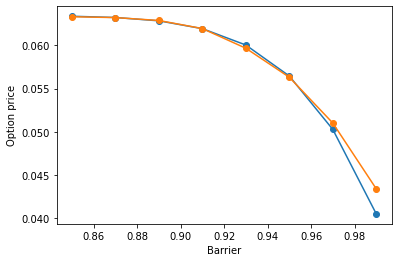

In [55]:
plt.plot(barrier_list, broadie_glassermen_price, marker = 'o', label = 'numerical')
plt.plot(barrier_list, df_barrier_pv.iloc[0], marker = 'o', label = 'numerical')
plt.xlabel('Barrier')
plt.ylabel('Option price')
plt.show()